In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from resNet_script import *
from models import *
# Create the dataset and dataloaders
datasets = compile_dataset("./images/")
train_loader, val_loader, test_loader = get_dataloaders(*datasets)
# Downloads and initializes the ResNet model from the PyTorch database
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in /home/axk6052/.cache/torch/hub/pytorch_vision_v0.10.0
/home/axk6052/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/axk6052/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
print(model(torch.zeros(1, 3, 224, 224)).shape)

torch.Size([1, 1000])


In [40]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def cam_gradient(dataloader, model):
    model = nn.Sequential(*list(model.children())[:-1])
    device = next(model.parameters()).device

    cam_gradients = []
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        inputs.requires_grad = True

        outputs = model(inputs).squeeze()
        _, predicted_classes = torch.max(outputs, dim=1)
        predicted_scores = nn.functional.softmax(outputs, dim=1)[range(len(inputs)), predicted_classes]

        model.zero_grad()
        predicted_scores.backward(torch.ones(len(inputs)).to(device))

        cam_gradient = inputs.grad.mean(dim=[2,3])
        cam_gradients.append(cam_gradient.cpu().numpy())

        # Overlay CAM on original image and display
        cam = cam_gradient.cpu().numpy()
        for i in range(len(inputs)):
            img = inputs[i].detach().numpy().transpose((1,2,0))
            cam_img = cam[i].reshape((1, 1, -1))
            cam_img = cam_img / np.max(cam_img) # normalize
            cam_img = np.tile(cam_img, (img.shape[0], img.shape[1], 1))
            alpha = 0.5
            overlayed_img = alpha * cam_img + (1 - alpha) * img
            plt.imshow(overlayed_img)
            plt.show()
            break
        break
    return cam_gradients

 

Using cache found in /home/axk6052/.cache/torch/hub/pytorch_vision_v0.10.0
/home/axk6052/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/axk6052/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


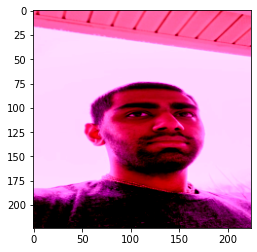

In [42]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Calculate the CAM gradients for each image in the batch
cam_grads = cam_gradient(test_loader, model)